<a href="https://www.kaggle.com/code/emadamani/fsl-triplet-score?scriptVersionId=265750121" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install keras-facenet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.4 MB/s eta 0:00:00
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10367 sha256=f2650e395721c010739fb60e7e3be8840645da4938f9c846548e23051d8a31c3
  Stored in directory: /root/.cache/pip/wheels/99/94/dd/cb1a65a7440ba6d508bd24346c15af0b1d24ff8b1cdb1c9959
Successfully built keras-facenet


# Librarys

In [2]:
from tensorflow.keras import layers, models, optimizers, ops, metrics, applications, losses, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from keras_facenet import FaceNet
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import numpy as np
import cv2
import os

2025-10-04 19:30:42.856017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759606243.245691      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759606243.355646      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
IMAGE_SIZE = 160 # images & input size

#The names of the folders whose images we want to use for the query set and support set,
#and the model will not see these at the time of the train.
infrence_data = ['000009', '000032', '000046']

# preprocessing

In [4]:
def process_image(image_path):
    
    image = tf.io.read_file(image_path)            
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 128.0
    return image

# read data

In [5]:
def path_label_imags(base_dir):
    images_label = []
    labels = []

    label = 0
    for folder in os.listdir(base_dir):
        
        if folder in infrence_data:
            continue
        
        files_path = os.path.join(base_dir, folder)
        
        for file in os.listdir(files_path):
            image_path = os.path.join(files_path, file)
            
            images_label.append(image_path)
            labels.append(label)
            
        label+=1
            
    return images_label, labels
        
    
base_dir = "/kaggle/input/casia-face-dataset/casia dataset"
images_path, labels = path_label_imags(base_dir)
print(len(images_path), len(labels))
print(f'Total Labels :{len(set(labels))}')

19894 19894
Total Labels :197


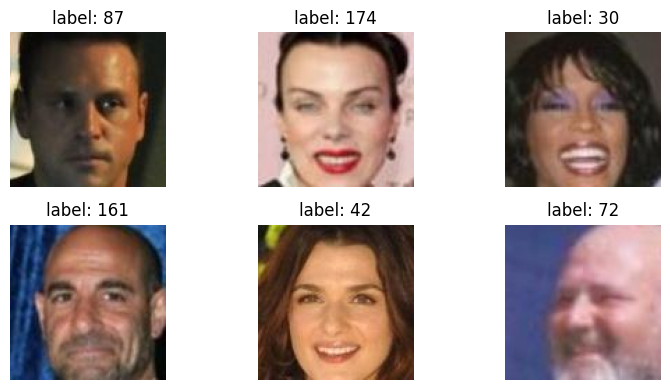

In [6]:
def open_img(img_paath):
    return cv2.imread(img_paath)[:,:,::-1]

plt.figure(figsize=(8, 4))

for i in range(6):
    random_idx = np.random.randint(len(images_path))
    plt.subplot(2, 3, i+1)   
    plt.imshow(open_img(images_path[random_idx]))
    plt.axis("off")
    plt.title(f'label: {labels[random_idx]}')

plt.tight_layout()
plt.show()

# creating data ternary set

In [7]:
def tree(data, labels):
    labels = np.array(labels)
    ancher_paths=[]
    positive_paths=[]
    negetive_paths=[]
    
    for idx in range(len(data)):
        ancher = data[idx]
        ancher_label = labels[idx]

        # positive 
        pos_candidates = np.where(labels == ancher_label)[0]
        pos_candidates = pos_candidates[pos_candidates != idx]
        # print(pos_candidates)
        if len(pos_candidates)>0:
            # for candid in pos_candidates:
            pos_idx = np.random.choice(pos_candidates)
            pos_data = data[pos_idx]

            # negative 
            neg_candidates = np.where(labels != ancher_label)[0]
            neg_idx = np.random.choice(neg_candidates)
            neg_data = data[neg_idx]


            ancher_paths.append(ancher)
            positive_paths.append(pos_data)
            negetive_paths.append(neg_data)
                
    return ancher_paths, positive_paths, negetive_paths

19894
19894
19894


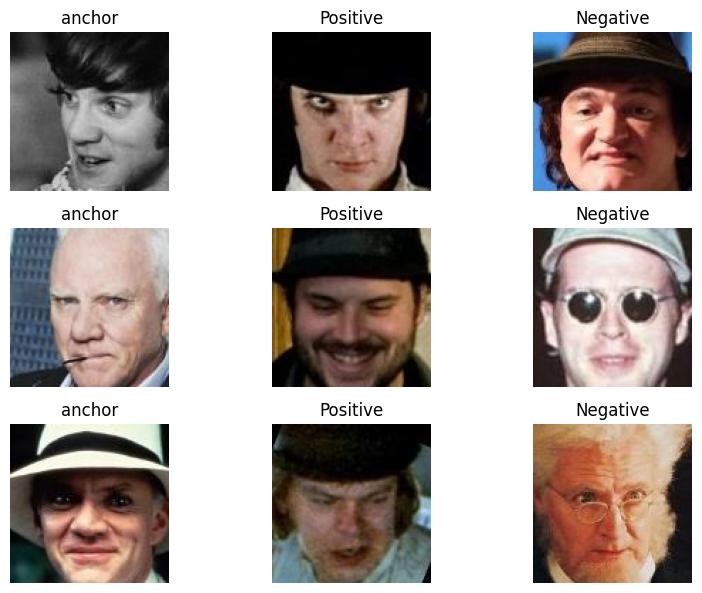

In [8]:
ancher_paths, positive_paths, negetive_paths = tree(images_path, labels)
print(len(ancher_paths))
print(len(positive_paths))
print(len(negetive_paths))

plt.figure(figsize=(8, 8))
j=0
for i in range(20, 23):
    j+=1
    plt.subplot(4, 3, j)   
    plt.imshow(open_img(ancher_paths[i]))
    plt.axis("off")
    plt.title(f'anchor')

    j+=1
    plt.subplot(4, 3, j)   
    plt.imshow(open_img(positive_paths[i]))
    plt.axis("off")
    plt.title('Positive')        

    j+=1
    plt.subplot(4, 3, j)   
    plt.imshow(open_img(negetive_paths[i]))
    plt.axis("off")
    plt.title('Negative')

plt.tight_layout()
plt.show()

# Converting data to TensorFlow datasets and image processing

In [9]:
dataset = tf.data.Dataset.from_tensor_slices((ancher_paths, positive_paths, negetive_paths))

def tree_preprocess(a, p, n):
    a = process_image(a)
    p = process_image(p)
    n = process_image(n)
    return (a, p, n)

dataset = dataset.map(tree_preprocess).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1759606273.091650      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759606273.092372      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# train test split

In [10]:
dataset_size = dataset.cardinality().numpy()
print(dataset_size)
train_size = int(0.8 * dataset_size)

train_data = dataset.take(train_size)
val_data = dataset.skip(train_size)
print(len(train_data))
print(len(val_data))

622
497
125


# Feature extraction network from images(Embedding image)

In [11]:
def backbone(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)):

    embedder = FaceNet()
    base_model = embedder.model  
    
    for layer in base_model.layers:
        layer.trainable = False

    x = layers.Dense(32, activation='relu')(base_model.output)
    
    x = layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(x)

    feature_extractor = models.Model(inputs=base_model.input, outputs=x)
    
    print("Feature extractor (FaceNet) model has been successfully built.")
    return feature_extractor

# custom distance layer for triplet networks

In [12]:
class DistanceLayer(layers.Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def call(self, ancher, positive, negative):
        ap_distance = ops.sum(tf.square(ancher - positive), -1)
        an_distance = ops.sum(tf.square(ancher - negative), -1)
        return (ap_distance, an_distance)

In [13]:
feature_extractor = backbone()

ancher_input = layers.Input(name='anchor', shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
positive_input = layers.Input(name='positive', shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
negative_input = layers.Input(name='negative', shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

ancher_network = feature_extractor(ancher_input)
positive_network = feature_extractor(positive_input)
negative_network = feature_extractor(negative_input)

distance_layer = DistanceLayer()

distances = distance_layer(
    
    ancher_network,
    positive_network,
    negative_network
)

siamese_trip_network = models.Model(inputs = [ancher_input, positive_input, negative_input], outputs = distances) 

Feature extractor (FaceNet) model has been successfully built.


In [14]:
class SiamiseModel(models.Model):
    def __init__(self, siamese_trip_network, margin=0.5):
        super().__init__()
        self.siamese_trip_network = siamese_trip_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name='loss')
        
    def call(self, inputs):
        return self.siamese_trip_network(inputs)

    ######################################################################## TRAIN STEP
    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_trip_network.trainable_weights)

        self.optimizer.apply_gradients(zip(gradients, self.siamese_trip_network.trainable_weights))

        self.loss_tracker.update_state(loss)
        return {'loss' : self.loss_tracker.result()}
    
    ######################################################################## TEST STEP
    def test_step(self, data):
        loss = self._compute_loss(data)
        self.loss_tracker.update_state(loss)
        return {'loss' : self.loss_tracker.result()}
        
    ####################################################################### compute_loss
    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_trip_network(data)
        loss = ap_distance - an_distance
        loss = tf.maximum(loss+self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]

In [15]:
siamese_model_2 = SiamiseModel(siamese_trip_network)
siamese_model_2.compile(optimizer=optimizers.Adam(0.0001))
siamese_model_2.fit(train_data, epochs=3, validation_data = val_data)

Epoch 1/3


I0000 00:00:1759606325.562162      76 service.cc:148] XLA service 0x7c77dc095b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759606325.563750      76 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759606325.563787      76 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1759606333.340958      76 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/497 ━━━━━━━━━━━━━━━━━━━━ 8:30:43 62s/step - loss: 0.0926

I0000 00:00:1759606340.143897      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


497/497 ━━━━━━━━━━━━━━━━━━━━ 189s 256ms/step - loss: 0.1219 - val_loss: 0.1105
Epoch 2/3
497/497 ━━━━━━━━━━━━━━━━━━━━ 94s 186ms/step - loss: 0.0763 - val_loss: 0.0940
Epoch 3/3
497/497 ━━━━━━━━━━━━━━━━━━━━ 96s 190ms/step - loss: 0.0615 - val_loss: 0.0883


# Inference Data Preparation: Query and Support Sets (Triplet Setup)

In the variable infrence_data, we randomly selected three folder names.
The model is not allowed to see or learn from the data inside these folders during the main training phase.
Later, these folders are used exclusively for evaluation — where each folder represents a distinct identity.

From each of these three folders, we randomly picked six images:

One image is used as part of the query set (acting as the anchor image during inference),

The remaining five images are used as the support set (potential positive or negative samples).

Thus, across all three folders:

We have 3 query images (one from each folder),

And 15 support images (five from each folder).

During inference, the query images (anchors) are compared against all support images to form triplets.
Each triplet consists of:

The anchor image (from the query set),

A positive image (from the same folder as the anchor), and

A negative image (from a different folder).

The trained model then computes the embedding distances for each triplet —
aiming for smaller distances between anchor–positive pairs and larger ones between anchor–negative pairs.
This setup allows the system to evaluate how well the model distinguishes between different identities that it has never seen during training.

In [16]:
#infrence_data = ['000009', '000032', '000046']
base_dir = "/kaggle/input/casia-face-dataset/casia dataset"
support_set_data=[]
support_set_label=[]

query_set={}

for i, folder in enumerate(infrence_data):
    folder_path = os.path.join(base_dir, folder)
    files=[]
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        files.append(file_path)
        
    items=np.random.choice(len(files), 6, replace=False)

    # query_set
    query_set[i]=files[items[0]]
    # support_set
    for f in items[1:]:
        support_set_data.append(files[f])
        support_set_label.append(i)
    
print(len(support_set_data))
print(len(support_set_label))
print()
print(len(query_set))

15
15

3


support set


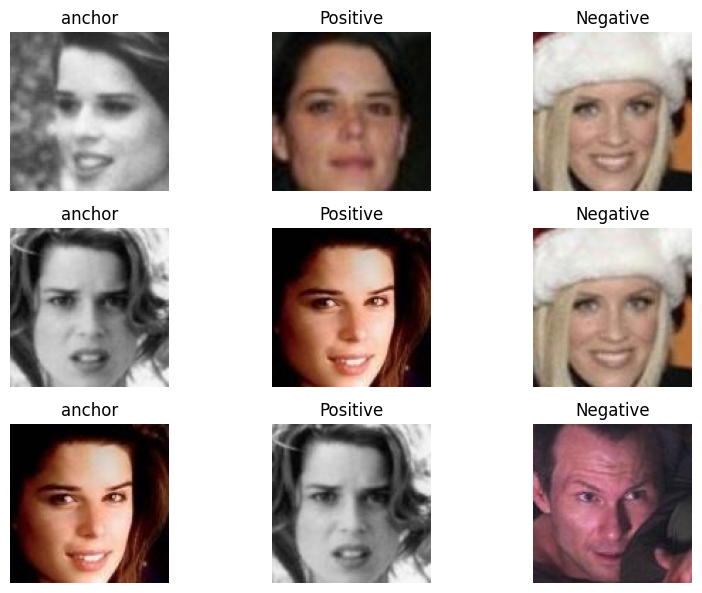

quary set


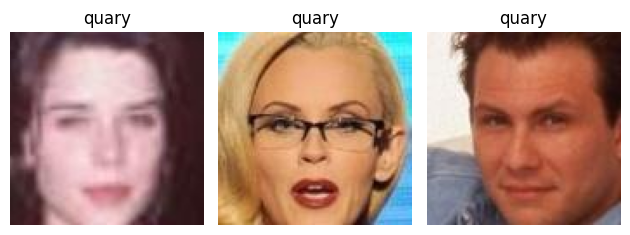

In [17]:
ancher_paths_test, positive_paths_test, negetive_paths_test = tree(support_set_data, support_set_label)

plt.figure(figsize=(8, 8))
j=0
for i in range(3):
    j+=1
    plt.subplot(4, 3, j)   
    plt.imshow(open_img(ancher_paths_test[i]))
    plt.axis("off")
    plt.title(f'anchor')

    j+=1
    plt.subplot(4, 3, j)   
    plt.imshow(open_img(positive_paths_test[i]))
    plt.axis("off")
    plt.title('Positive')        

    j+=1
    plt.subplot(4, 3, j)   
    plt.imshow(open_img(negetive_paths_test[i]))
    plt.axis("off")
    plt.title('Negative')
    
print('support set')
plt.tight_layout()
plt.show()


j=0
for i in range(3):
    j+=1
    plt.subplot(1, 3, j)   
    plt.imshow(open_img(query_set[i]))
    plt.axis("off")
    plt.title(f'quary')

print('quary set')
plt.tight_layout()
plt.show()

# train with support set data¶

In [18]:
dataset_test = tf.data.Dataset.from_tensor_slices((ancher_paths_test, positive_paths_test, negetive_paths_test))

def tree_preprocess(a, p, n):
    a = process_image(a)
    p = process_image(p)
    n = process_image(n)
    return (a, p, n)

dataset_test = dataset_test.map(tree_preprocess).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
siamese_model_2.fit(dataset_test, epochs=3)

Epoch 1/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 7.7717e-04
Epoch 2/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 1.5329e-04
Epoch 3/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0000e+00


# Triplet Inference: Calculating Distances Between Query and Support Images

In this section, we evaluate the performance of the Triplet model by comparing each image in the Query set with all images in the Support set.

For each iteration:

Each Query image is treated as the Anchor,

All Support images are treated as Positive samples,

And since we don’t need a real negative sample during inference, we replace the Negative input with a zero matrix of the same size.

The model then computes the embedding distance between each Anchor–Positive pair, and the results are stored in the distances list.
Finally, the images with the smallest distance values are identified and printed as the closest matches for each Query.

item 0 from Query set
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
item 1 from Query set
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━

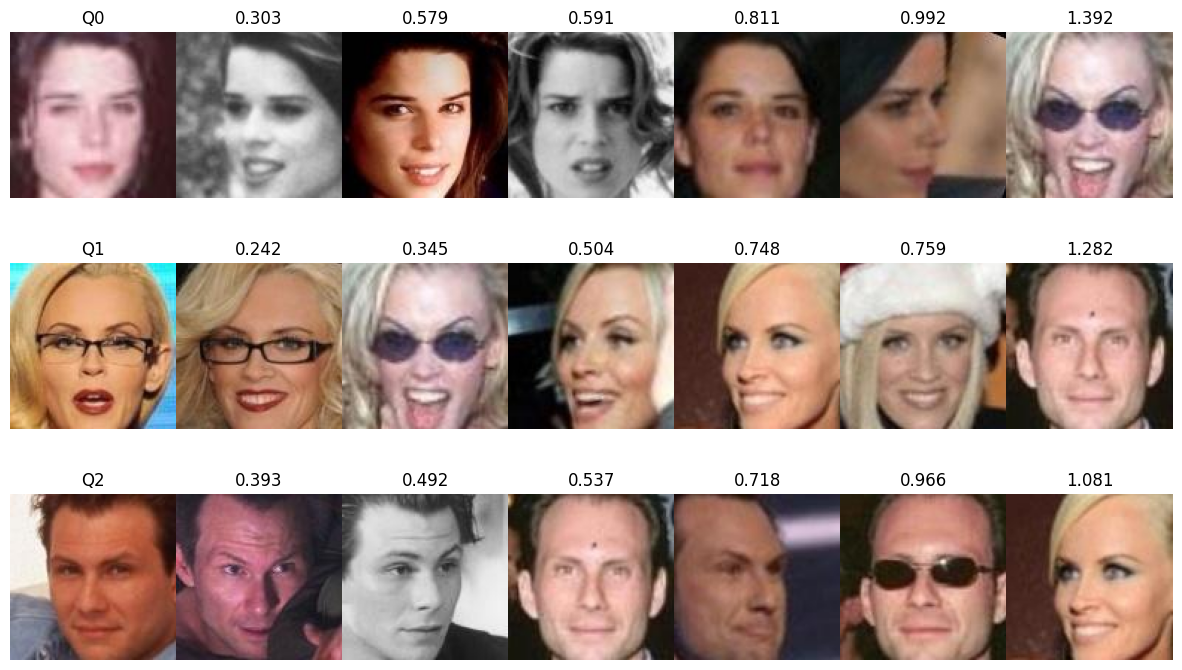

In [19]:
result = []

for q in range(len(query_set)):
    print(f'item {q} from Query set')

    query = np.expand_dims(process_image(query_set[q]), axis=0)

    distances = []
    for i, s in enumerate(support_set_data):
        support = np.expand_dims(process_image(s), axis=0)

        dummy_neg = np.zeros_like(query)

        ap_dist, an_dist = siamese_model_2.predict([query, support, dummy_neg])

        distances.append([q, support_set_label[i], ap_dist[0], s])

    x = sorted(distances, key=lambda a: a[2])
    result.append(x)


plt.figure(figsize=(15, 3*len(result))) 

for idx, x in enumerate(result):

    plt.subplot(len(result), 7, idx*7 + 1)
    plt.imshow(open_img(query_set[idx]))
    plt.axis("off")
    plt.title(f'Q{idx}')
    

    for i in range(6):
        plt.subplot(len(result), 7, idx*7 + i + 2)
        plt.imshow(open_img(x[i][3]))
        plt.axis("off")
        plt.title(round(x[i][2], 3))

plt.subplots_adjust(wspace=0, hspace=0)  